# Three Body Problem: Neural Network Training

A simple neural network is trained to learn approximate solutions to the three body problem.<br>
Data is sampled from three body systems that are perturbed versions of the Sun-Earth-Jupiter system.

In [1]:
# Library imports
import tensorflow as tf
import rebound
import numpy as np
import datetime
import matplotlib.pyplot as plt

# Aliases
keras = tf.keras

In [2]:
# Local imports
from utils import load_vartbl, save_vartbl, plot_style, range_inc
from tf_utils import gpu_grow_memory, TimeHistory
from tf_utils import plot_loss_hist, EpochLoss, TimeHistory
from tf_utils import Identity

from orbital_element import OrbitalElementToConfig, ConfigToOrbitalElement, MeanToTrueAnomaly, G_
from orbital_element import make_model_elt_to_cfg, make_model_cfg_to_elt

from jacobi import CartesianToJacobi, JacobiToCartesian

from g3b_data import make_traj_elts, make_data_g3b, make_datasets_g3b, traj_to_batch
from g3b_data import make_datasets_solar, make_datasets_hard
from g3b_data import combine_datasets_g3b, combine_datasets_solar
from sej_data import load_data_sej, make_datasets_sej, combine_datasets_sej
from sej_data import orb_elts0, orb_elt_summary

from g3b_plot import plot_orbit_q, plot_orbit_v, plot_orbit_a, plot_orbit_energy, plot_orbit_element
from g3b import KineticEnergy_G3B, PotentialEnergy_G3B, Momentum_G3B, AngularMomentum_G3B
from g3b import VectorError, EnergyError
from g3b import Motion_G3B, make_physics_model_g3b
from g3b import fit_model
from g3b_model_math import make_position_model_g3b_math, make_model_g3b_math
from g3b_model_nn import make_position_model_g3b_nn, make_model_g3b_nn
from g3b_model_nn import baseline_loss

In [3]:
# Set active GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[1:2], 'GPU')

In [4]:
# Grow GPU memory (must be first operation in TF)
# gpu_grow_memory()

In [5]:
# Lightweight serialization
# fname = '../data/g3b/g3b_train.pickle'
fname = '../data/sej/sej_train.pickle'
vartbl = load_vartbl(fname)

In [6]:
# Set plot style
plot_style()

### Load Data for General Three Body Problem

In [7]:
# Description of datasets to be loaded
n_years = 100
sample_freq = 10
traj_size = n_years * sample_freq + 1

In [8]:
# Configuration for loading data sets
# num_data_sets = 50
num_data_sets = 5
batch_size = 256
# num_gpus = 1
# full_batch_size = num_gpus * batch_size

# Set size of tiny data sets
n_traj_tiny = batch_size

# Set starting random seed
seed0 = 42

In [9]:
# Create a tiny data set with one batch of solar type orbits
ds_tiny_solar, _ , _ = \
    make_datasets_solar(n_traj=n_traj_tiny, vt_split=0.0, 
                        n_years=n_years, sample_freq=sample_freq,
                        batch_size=batch_size, seed=seed0)

Loaded data from ../data/g3b/1789961721.pickle.


W0823 13:59:36.827702 140281135286080 deprecation.py:323] From /home/michael/anaconda3/envs/nbody/lib/python3.7/site-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
# Build combined solar data sets
# ds_solar_trn, ds_solar_val, ds_solar_tst = \
#     combine_datasets_solar(num_data_sets=num_data_sets, batch_size=batch_size, seed0=seed0)

### Load Data for Perturbed Sun-Earth-Jupiter System

In [11]:
# Orbital perturbation scales
scale_factor = 1.0
sd_q = scale_factor * np.array([0.00, 0.01, 0.05])
sd_v = sd_q

In [12]:
# Create a tiny data set with one batch of perturbed SEJ orbits
ds_tiny_sej, _ , _ = \
    make_datasets_sej(n_traj=n_traj_tiny, vt_split=0.0, n_years=n_years, sample_freq=sample_freq,
                      sd_q=sd_q, sd_v=sd_v,
                      batch_size=batch_size, seed=seed0,
                      assemble_datasets=True)

Loaded data from ../data/sej/1261268456.pickle.


In [13]:
# Create a tiny data set with the unperturbed SEJ system
ds_sej0, _, _ = \
    make_datasets_sej(n_traj=n_traj_tiny, vt_split=0.0, n_years=n_years, sample_freq=sample_freq,
                      sd_q=0.0, sd_v=0.0,
                      batch_size=batch_size, seed=0,
                      assemble_datasets=True)

Loaded data from ../data/sej/1521397475.pickle.


In [14]:
# Table of data sets keyed by scale factor
data_by_factor = dict()

In [15]:
# Build combined SEJ data sets with base scale factor
scale_factor = 1.0
ds_trn, ds_val, ds_tst = \
    combine_datasets_sej(num_data_sets=num_data_sets, batch_size=batch_size, 
                         seed0=seed0, scale_factor=scale_factor)

Loaded data from ../data/sej/1683869768.pickle.


Loaded data from ../data/sej/723273359.pickle.
Loaded data from ../data/sej/2662480066.pickle.
Loaded data from ../data/sej/1320348092.pickle.
Loaded data from ../data/sej/868556281.pickle.



In [16]:
# Update data by scale factor
data_by_factor[scale_factor] = (ds_trn, ds_val, ds_tst)

***Choose Data Set for Analysis: Solar vs. SEJ***

In [17]:
# Alias ds_trn, ds_val, ds_tst to selected source

# The selected data type for this analysis
data_type = 'SEJ'

# # Tables mapping data type to tuple of data sets
# data_by_type = {
#     # 'solar': (ds_tiny_solar, ds_solar_trn, ds_solar_val, ds_solar_tst),
#     'SEJ': (ds_tiny_sej, ds_sej_trn, ds_sej_val, ds_sej_tst)
# }

# # Perform the aliasing
# ds_tiny, ds_trn, ds_val, ds_tst = data_by_type[data_type]

ds_tiny = ds_tiny_sej

### Create the Kepler-Jacobi Model as a Benchmark

In [18]:
model_kj = make_model_g3b_math(traj_size=traj_size, batch_size=batch_size)

In [19]:
optimizer = keras.optimizers.Adam(learning_rate=0.0)

loss = {'q': VectorError(name='q_loss'),
        'v': VectorError(name='v_loss'),
        'a': VectorError(regularizer=1.0, name='a_loss'),
        'q0_rec': VectorError(name='q0_loss'),
        'v0_rec': VectorError(name='v0_loss'),
        'H': EnergyError(name='H_loss'),
        'P': VectorError(name='P_loss', regularizer=1.0E-6),
        'L': VectorError(name='L_loss'),
       }

metrics = None

loss_weights = {'q': 1.0,
                'v': 1.0,
                'a': 1.0,
                'q0_rec': 1.0E4,
                'v0_rec': 1.0E4,
                'H': 1.0,
                'P': 1.0,
                'L': 1.0}

In [20]:
# Compile the full mathematical model
model_kj.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [21]:
# Evaluate KJ model on unperturbed SEJ data set
model_kj.evaluate(ds_sej0)

1/1 [==============================] - 3s 3s/step - loss: 6.7071e-05 - q_loss: 1.9321e-05 - v_loss: 1.9308e-05 - a_loss: 2.8442e-05 - q0_rec_loss: 9.7934e-15 - v0_rec_loss: 2.0469e-14 - H_loss: 6.6203e-14 - P_loss: 3.6133e-14 - L_loss: 1.1413e-14


[6.707102875225246e-05,
 1.9320656e-05,
 1.9308249e-05,
 2.844182e-05,
 9.793443e-15,
 2.0469324e-14,
 6.620291e-14,
 3.6132582e-14,
 1.1412751e-14]

In [22]:
# Evaluate KJ model on tiny data set
model_kj.evaluate(ds_tiny)

1/1 [==============================] - 0s 137ms/step - loss: 6.8487e-05 - q_loss: 1.9837e-05 - v_loss: 1.9812e-05 - a_loss: 2.8838e-05 - q0_rec_loss: 2.0671e-14 - v0_rec_loss: 1.9992e-14 - H_loss: 9.5866e-14 - P_loss: 3.8770e-14 - L_loss: 2.0161e-14


[6.848739576525986e-05,
 1.9836736e-05,
 1.9811845e-05,
 2.883841e-05,
 2.0670675e-14,
 1.9992044e-14,
 9.5865854e-14,
 3.8770395e-14,
 2.0161029e-14]

In [23]:
# Evaluate KJ model on full validation data
model_kj.evaluate(ds_val)

35/35 [==============================] - 5s 131ms/step - loss: 6.7764e-05 - q_loss: 1.9676e-05 - v_loss: 1.9652e-05 - a_loss: 2.8436e-05 - q0_rec_loss: 1.5596e-14 - v0_rec_loss: 1.4356e-14 - H_loss: 9.2961e-14 - P_loss: 3.8784e-14 - L_loss: 2.0182e-14


[6.776364025427029e-05,
 1.9675517e-05,
 1.9652058e-05,
 2.8435767e-05,
 1.559638e-14,
 1.4356488e-14,
 9.2961446e-14,
 3.8784294e-14,
 2.0181556e-14]

### Train the Neural Network Model

In [32]:
# Configuration for neural network model architecture
hidden_sizes = [64, 16]
skip_layers = True

# Training configuration
learning_rate = 5.0E-8 # this is about 0.001 x the validation loss on the KJ model
kernel_reg = 1.0E-8
activity_reg = 0.0

In [33]:
# Build neural network model
model_nn = make_model_g3b_nn(hidden_sizes=hidden_sizes, skip_layers=skip_layers, 
                             kernel_reg=kernel_reg, activity_reg=activity_reg,
                             traj_size=traj_size, batch_size=batch_size)

In [34]:
# model_nn.summary()

In [35]:
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# optimizer = keras.optimizers.Adadelta()

In [36]:
# Compile the NN model
model_nn.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [37]:
# Evaluate the NN model on the unperturbed orbit
model_nn.evaluate(ds_sej0)

1/1 [==============================] - 2s 2s/step - loss: 6.7071e-05 - q_loss: 1.9321e-05 - v_loss: 1.9308e-05 - a_loss: 2.8442e-05 - q0_rec_loss: 9.7934e-15 - v0_rec_loss: 2.0469e-14 - H_loss: 6.6203e-14 - P_loss: 3.6133e-14 - L_loss: 1.1413e-14


[6.707102875225246e-05,
 1.9320656e-05,
 1.9308249e-05,
 2.844182e-05,
 9.793443e-15,
 2.0469324e-14,
 6.620291e-14,
 3.6132582e-14,
 1.1412751e-14]

In [38]:
# Evaluate the NN model on the tiny data set
# model_nn.evaluate(ds_tiny)

In [39]:
# Table with baseline losses by scale factor
baseline_tbl = dict()

In [40]:
# Evaluate the KJ model on the full validation data; save as baseline
hist0, q_loss_baseline = baseline_loss(model_kj, ds_val)
baseline_tbl[scale_factor] = q_loss_baseline

35/35 [==============================] - 5s 134ms/step - loss: 6.7764e-05 - q_loss: 1.9676e-05 - v_loss: 1.9652e-05 - a_loss: 2.8436e-05 - q0_rec_loss: 1.5596e-14 - v0_rec_loss: 1.4356e-14 - H_loss: 9.2961e-14 - P_loss: 3.8784e-14 - L_loss: 2.0182e-14


In [41]:
# Set up training - shared variables

# Suffix to the model name reflects layer sizes
suffix = '_'.join(str(sz) for sz in hidden_sizes)

# The model code is g3b or sej based on type of data
if data_type == 'solar':   
    model_code = 'g3b'
elif data_type == 'SEJ':
    model_code = 'sej'

# The folder is the same as the model code
folder = model_code

# How often to save weights to disk
save_freq = 'epoch'

### Train on Unperturbed Model (ds_sej0)

In [42]:
# Set up training - unperturbed SEJ system (ds_sej0)
model_name = f'model_{model_code}_nn_{suffix}_sej0'

# Number of training epochs
num_batches=1
epochs_per_batch = 5

# H5 file with model weights
model_h5 = f'../models/{folder}/{model_name}.h5'
# Name of the loss history in vartbl
hist_name = model_name.replace('model_', 'hist_')

# Status
print(f'model_nn.name = {model_nn.name}')
print(f'model_h5 = {model_h5}')
print(f'hist_name = {hist_name}')

model_nn.name = model_g3b_nn_64_16
model_h5 = ../models/sej/model_sej_nn_64_16_sej0.h5
hist_name = hist_sej_nn_64_16_sej0


In [43]:
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics, loss_weights=loss_weights)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    print(f'Unable to load {model_name} from {model_h5}. Fitting...')
    hist = hist0
    for i in range_inc(num_batches):
        ts = datetime.datetime.now()
        st = ts.strftime('%Y-%m-%d %H:%M:%S')
        print(f'*** Training batch {i:3} *** {st}')
        hist = fit_model(model=model_nn,
                         model_name=model_name,
                         folder=folder,
                         ds=ds_sej0, 
                         epochs=epochs_per_batch,
                         save_freq=save_freq,
                         prev_history = hist, 
                         batch_num=i)
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

Loaded model_sej_nn_64_16_sej0 from ../models/sej/model_sej_nn_64_16_sej0.h5.


In [44]:
# Evaluate trained model on unperturbed data set
model_nn.evaluate(ds_sej0)

1/1 [==============================] - 3s 3s/step - loss: 1.2885e-05 - q_loss: 4.4936e-06 - v_loss: 4.4890e-06 - a_loss: 3.8605e-06 - q0_rec_loss: 9.7934e-15 - v0_rec_loss: 2.0469e-14 - H_loss: 1.2824e-08 - P_loss: 3.7907e-14 - L_loss: 2.8458e-08


[1.288468138227472e-05,
 4.493584e-06,
 4.488994e-06,
 3.8605167e-06,
 9.793443e-15,
 2.0469324e-14,
 1.2824296e-08,
 3.7907293e-14,
 2.8457942e-08]

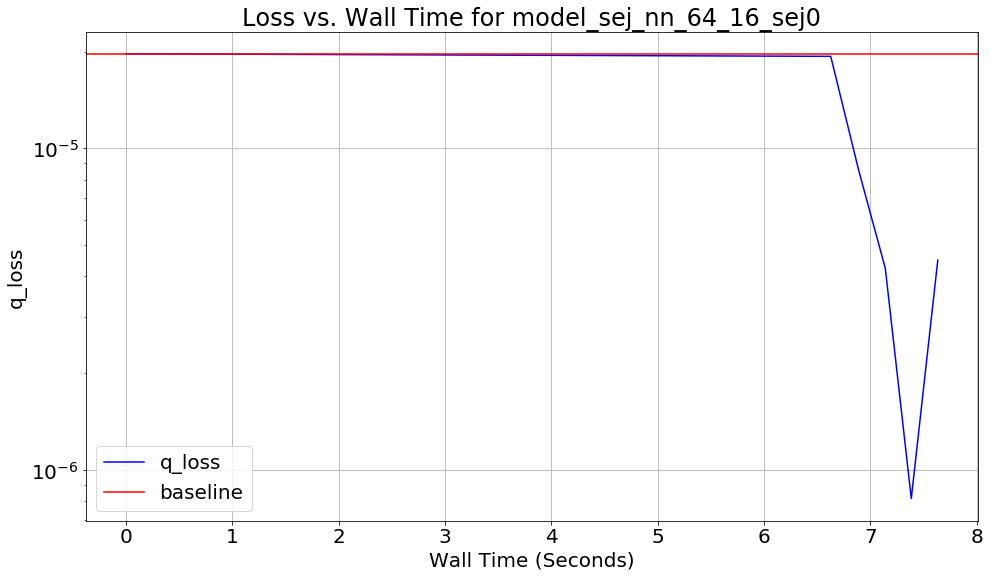

In [45]:
# Plot the loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_name, key='q_loss', baseline=q_loss_baseline)

### Train on Tiny Data Set

In [46]:
# Set up training - tiny data set
model_name = f'model_{model_code}_nn_{suffix}_tiny'

# Number of training epochs
num_batches = 1
epochs_per_batch = 10

# H5 file with model weights
model_h5 = f'../models/{folder}/{model_name}.h5'
# Name of the loss history in vartbl
hist_name = model_name.replace('model_', 'hist_')

# Status
print(f'model_nn.name = {model_nn.name}')
print(f'model_h5 = {model_h5}')
print(f'hist_name = {hist_name}')

model_nn.name = model_g3b_nn_64_16
model_h5 = ../models/sej/model_sej_nn_64_16_tiny.h5
hist_name = hist_sej_nn_64_16_tiny


In [47]:
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics, loss_weights=loss_weights)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    print(f'Unable to load {model_name} from {model_h5}. Fitting...')
    hist = hist0
    for i in range_inc(num_batches):
        ts = datetime.datetime.now()
        st = ts.strftime('%Y-%m-%d %H:%M:%S')
        print(f'*** Training batch {i:3} *** {st}')
        hist = fit_model(model=model_nn,
                         model_name=model_name,
                         folder=folder,
                         ds=ds_tiny, 
                         epochs=epochs_per_batch,
                         save_freq=save_freq,
                         prev_history = hist, 
                         batch_num=i)
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

Unable to load model_sej_nn_64_16_tiny from ../models/sej/model_sej_nn_64_16_tiny.h5. Fitting...
*** Training batch   1 *** 2019-08-23 14:03:51
Epoch 1/10

Epoch 0001; loss 1.25e-05; elapsed 0:00:07
1/1 [==============================] - 7s 7s/step - loss: 1.2546e-05 - q_loss: 4.1850e-06 - v_loss: 4.2767e-06 - a_loss: 4.0424e-06 - q0_rec_loss: 2.0671e-14 - v0_rec_loss: 1.9992e-14 - H_loss: 1.1973e-08 - P_loss: 3.9447e-14 - L_loss: 2.9548e-08
Epoch 2/10

Epoch 0002; loss 4.09e-06; elapsed 0:00:08
1/1 [==============================] - 0s 245ms/step - loss: 4.0885e-06 - q_loss: 9.6573e-07 - v_loss: 9.5727e-07 - a_loss: 2.0698e-06 - q0_rec_loss: 2.0671e-14 - v0_rec_loss: 1.9992e-14 - H_loss: 7.6884e-10 - P_loss: 3.9311e-14 - L_loss: 9.4509e-08
Epoch 3/10

Epoch 0003; loss 5.32e-06; elapsed 0:00:08
1/1 [==============================] - 0s 191ms/step - loss: 5.3239e-06 - q_loss: 1.2004e-06 - v_loss: 1.1890e-06 - a_loss: 2.9096e-06 - q0_rec_loss: 2.0671e-14 - v0_rec_loss: 1.9992e-14 - H_los

In [48]:
model_nn.evaluate(ds_tiny)

1/1 [==============================] - 0s 115ms/step - loss: 3.7289e-06 - q_loss: 8.5015e-07 - v_loss: 8.3101e-07 - a_loss: 2.0420e-06 - q0_rec_loss: 2.0671e-14 - v0_rec_loss: 1.9992e-14 - H_loss: 1.7568e-10 - P_loss: 3.9476e-14 - L_loss: 5.1054e-09


[3.7288900784915313e-06,
 8.5014705e-07,
 8.31012e-07,
 2.0420423e-06,
 2.0670675e-14,
 1.9992044e-14,
 1.7568363e-10,
 3.9476292e-14,
 5.105355e-09]

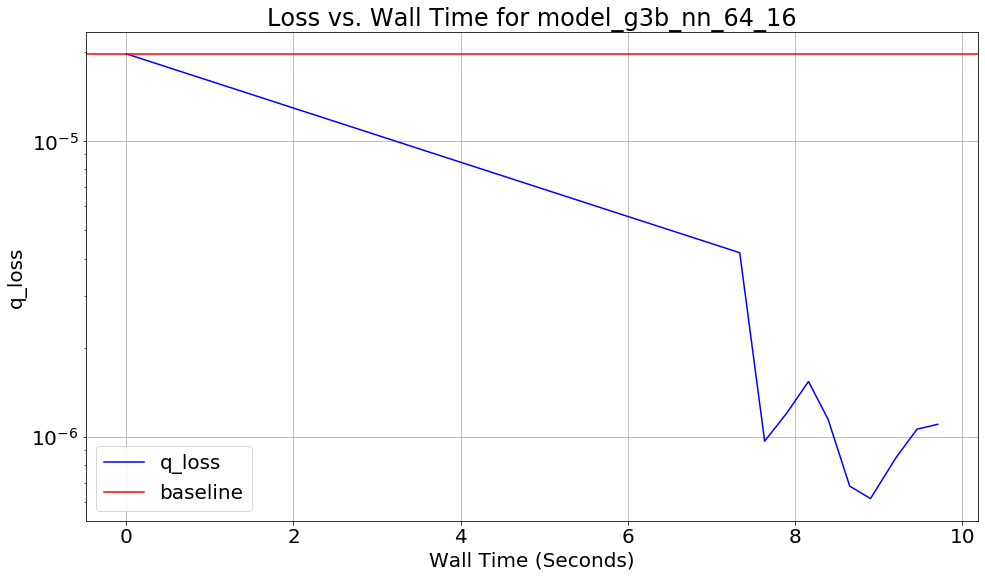

In [49]:
# Plot the loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_nn.name, key='q_loss', baseline=q_loss_baseline)

### Train on Full Data Set with Perturbation Scale Factor = 1.0

In [50]:
# Scale factor
scale_factor = 1.0

# Data for this scale factor
ds_trn, ds_val, ds_tst = data_by_factor[scale_factor]

In [51]:
# Evaluate the KJ model on the validation data; save as baseline
hist0, q_loss_baseline = baseline_loss(model_kj, ds_val)
baseline_tbl[scale_factor] = q_loss_baseline

35/35 [==============================] - 4s 128ms/step - loss: 6.7764e-05 - q_loss: 1.9676e-05 - v_loss: 1.9652e-05 - a_loss: 2.8436e-05 - q0_rec_loss: 1.5596e-14 - v0_rec_loss: 1.4356e-14 - H_loss: 9.2961e-14 - P_loss: 3.8784e-14 - L_loss: 2.0182e-14


### Describe Covariance of Dataset Orbital Elements

In [57]:
# List of orbital elements in the cov matrix
elt_names = ['a1', 'a2', 'e1', 'e2', 'inc1', 'inc2', 'Omega1', 'Omega2', 'omega1', 'omega2', 'f1', 'f2']
# limit to the interesting ones
elt_names = elt_names[0:6]

In [91]:
def orb_elt_summary(orb_elt):
    """Print a summary of the initial orbital elements in a data set"""
    # List of orbital elements in the cov matrix
    elt_names = ['a1', 'a2', 'e1', 'e2', 'inc1', 'inc2', 
                 'Omega1', 'Omega2', 'omega1', 'omega2', 'f1', 'f2']
    # Compute mean, std, min and max of orbital elemetns
    elt_mean = np.mean(orb_elt, axis=0)
    elt_std = np.std(orb_elt, axis=0)
    elt_min = np.min(orb_elt, axis=0)
    elt_max = np.max(orb_elt, axis=0)    
    
    # limit to the interesting ones
    elt_names = elt_names[0:6]

    # Display summary statistics of orbital elements
    print(f'element:  mean     :  std dev  :  min      :  max')
    for i, elt_name in enumerate(elt_names):
        print(f'{elt_name:6} : {elt_mean[i]:9.6f} : {elt_std[i]:9.6f} : '
              f'{elt_min[i]:9.6f} : {elt_max[i]:9.6f}')


In [ ]:
# Get initial orbital elements of this dataset
orb_elt = orb_elts0(ds_val)

In [92]:
# Summarize initial orbital elements of this dataset
orb_elt_summary(orb_elt)

element:  mean     :  std dev  :  min      :  max
a1     :  1.000418 :  0.020790 :  0.925173 :  1.084733
a2     :  5.205126 :  0.110135 :  4.820860 :  5.694392
e1     :  0.020275 :  0.009033 :  0.000552 :  0.057580
e2     :  0.049871 :  0.010345 :  0.009383 :  0.095552
inc1   :  0.008057 :  0.006083 :  0.000012 :  0.037704
inc2   :  0.023512 :  0.008534 :  0.009248 :  0.056155


In [80]:
# Set up training - full data, scale factor = 1

# Number of training epochs
num_batches=1
epochs_per_batch = 5

# Integer scale factor
sfi = int(scale_factor)

# Name of this model including scale factor
model_name = f'model_{model_code}_nn_{suffix}_sf_{sfi}'

# H5 file with model weights
model_h5 = f'../models/{folder}/{model_name}.h5'
# Name of the loss history in vartbl
hist_name = model_name.replace('model_', 'hist_')

# Status
print(f'Training for {num_batches} batches of {epochs_per_batch} epochs each.')
print(f'model_name = {model_name}')
print(f'model_h5 = {model_h5}')
print(f'hist_name = {hist_name}')

Training for 1 batches of 5 epochs each.
model_name = model_sej_nn_64_16_sf_1
model_h5 = ../models/sej/model_sej_nn_64_16_sf_1.h5
hist_name = hist_sej_nn_64_16_sf_1


### Run the Training

In [93]:
# Attempt to load model or train on selected number of epochs
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics, loss_weights=loss_weights)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    print(f'Unable to load {model_name} from {model_h5}. Fitting...')
    hist = hist0
    for i in range_inc(num_batches):
        ts = datetime.datetime.now()
        st = ts.strftime('%Y-%m-%d %H:%M:%S')
        print(f'*** Training batch {i:3} *** {st}')
        hist = fit_model(model=model_nn,
                         model_name=model_name,
                         folder=folder,
                         ds=ds_trn, 
                         epochs=epochs_per_batch,
                         save_freq=save_freq,
                         prev_history = hist, 
                         batch_num=i)    
        vartbl[hist_name] = hist
        save_vartbl(vartbl, fname)

Loaded model_sej_nn_64_16_sf_1 from ../models/sej/model_sej_nn_64_16_sf_1.h5.


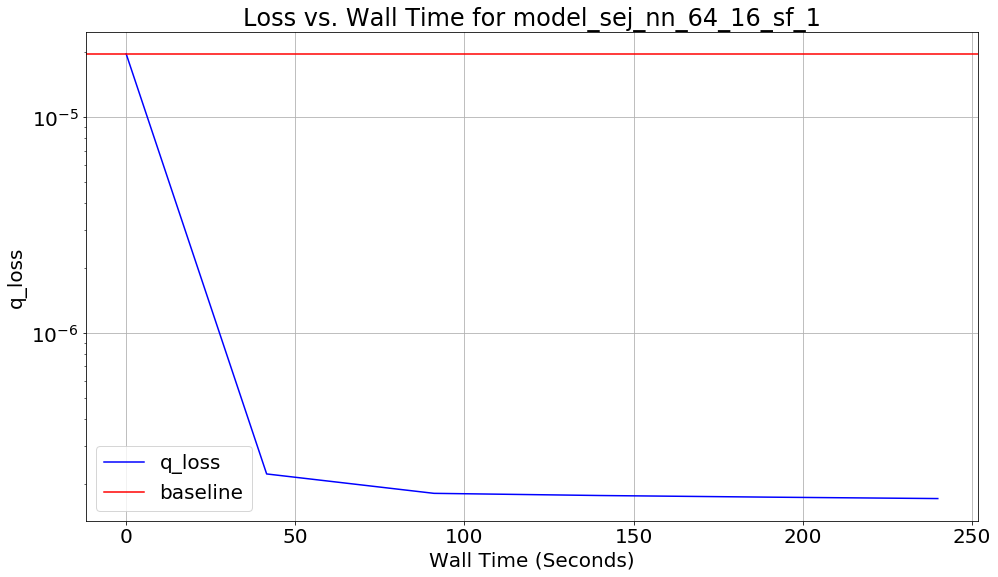

In [94]:
# Plot the loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_name, key='q_loss', baseline=q_loss_baseline)

In [95]:
# Plot the total loss
# fig, ax = plot_loss_hist(hist=hist, model_name=model_nn.name, key='loss')

In [96]:
# Evaluate the trained model on the validation data
model_nn.evaluate(ds_val)

35/35 [==============================] - 7s 188ms/step - loss: 1.2446e-06 - q_loss: 1.5281e-07 - v_loss: 1.3971e-07 - a_loss: 9.5163e-07 - q0_rec_loss: 1.5596e-14 - v0_rec_loss: 1.4356e-14 - H_loss: 1.0152e-13 - P_loss: 3.9335e-14 - L_loss: 1.0712e-10


[1.2445603130929937e-06,
 1.528081e-07,
 1.3970813e-07,
 9.5163404e-07,
 1.559638e-14,
 1.4356488e-14,
 1.01519975e-13,
 3.9334682e-14,
 1.0711654e-10]

In [ ]:
# Evaluate the trained model on the test data
# model_nn.evaluate(ds_tst)

### Train on Full Data Set with Perturbation Scale Factor = 2.0

In [97]:
# Build combined SEJ data sets with scale factor = 2
scale_factor = 2.0

# Data for this scale factor
ds_trn, ds_val, ds_tst = \
    combine_datasets_sej(num_data_sets=num_data_sets, batch_size=batch_size, 
                         seed0=seed0, scale_factor=scale_factor)

Loaded data from ../data/sej/2569572219.pickle.


Loaded data from ../data/sej/3597212092.pickle.
Loaded data from ../data/sej/1674012657.pickle.
Loaded data from ../data/sej/3016210063.pickle.
Loaded data from ../data/sej/3467657930.pickle.



In [98]:
# Update data by scale factor
data_by_factor[scale_factor] = (ds_trn, ds_val, ds_tst)

In [100]:
# Get initial orbital elements of this dataset
orb_elt = orb_elts0(ds_val)

In [101]:
# Summarize initial orbital elements of this dataset
orb_elt_summary(orb_elt)

element:  mean     :  std dev  :  min      :  max
a1     :  1.001697 :  0.041657 :  0.856044 :  1.177283
a2     :  5.210714 :  0.220500 :  4.471109 :  6.237769
e1     :  0.030032 :  0.015236 :  0.000077 :  0.098521
e2     :  0.053590 :  0.019586 :  0.001280 :  0.142165
inc1   :  0.016115 :  0.012166 :  0.000024 :  0.074634
inc2   :  0.026905 :  0.014575 :  0.008545 :  0.090833


In [102]:
# Evaluate the NN model on the full validation data; save as baseline
hist0, q_loss_baseline = baseline_loss(model_kj, ds_val)
baseline_tbl[scale_factor] = q_loss_baseline

35/35 [==============================] - 4s 114ms/step - loss: 6.7938e-05 - q_loss: 2.0025e-05 - v_loss: 1.9968e-05 - a_loss: 2.7945e-05 - q0_rec_loss: 1.7878e-14 - v0_rec_loss: 1.6894e-14 - H_loss: 9.5447e-14 - P_loss: 3.8691e-14 - L_loss: 2.0115e-14


In [103]:
# Set up training - full data, scale factor = 2

# Number of training epochs
num_batches=1
epochs_per_batch = 5

# Integer scale factor
sfi = int(scale_factor)

# Name of this model including scale factor
model_name = f'model_{model_code}_nn_{suffix}_sf_{sfi}'

# H5 file with model weights
model_h5 = f'../models/{folder}/{model_name}.h5'
# Name of the loss history in vartbl
hist_name = model_name.replace('model_', 'hist_')

# Status
print(f'Training for {num_batches} batches of {epochs_per_batch} epochs each.')
print(f'model_name = {model_name}')
print(f'model_h5 = {model_h5}')
print(f'hist_name = {hist_name}')

Training for 1 batches of 5 epochs each.
model_name = model_sej_nn_64_16_sf_2
model_h5 = ../models/sej/model_sej_nn_64_16_sf_2.h5
hist_name = hist_sej_nn_64_16_sf_2


In [104]:
# Attempt to load model or train on selected number of epochs
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics, loss_weights=loss_weights)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    print(f'Unable to load {model_name} from {model_h5}. Fitting...')
    hist = hist0
    for i in range_inc(num_batches):
        ts = datetime.datetime.now()
        st = ts.strftime('%Y-%m-%d %H:%M:%S')
        print(f'*** Training batch {i:3} *** {st}')
        hist = fit_model(model=model_nn,
                         model_name=model_name,
                         folder=folder,
                         ds=ds_trn, 
                         epochs=epochs_per_batch,
                         save_freq=save_freq,
                         prev_history = hist, 
                         batch_num=i)
    
        vartbl[hist_name] = hist
        save_vartbl(vartbl, fname)

Loaded model_sej_nn_64_16_sf_2 from ../models/sej/model_sej_nn_64_16_sf_2.h5.


In [105]:
# Evaluate the trained model on the validation data
model_nn.evaluate(ds_val)

35/35 [==============================] - 6s 172ms/step - loss: 1.1457e-06 - q_loss: 1.8752e-07 - v_loss: 1.7111e-07 - a_loss: 7.8640e-07 - q0_rec_loss: 1.7878e-14 - v0_rec_loss: 1.6894e-14 - H_loss: 1.4454e-10 - P_loss: 3.9338e-14 - L_loss: 1.9097e-10


[1.1457172506977387e-06,
 1.8752088e-07,
 1.711052e-07,
 7.8639977e-07,
 1.7877672e-14,
 1.6894065e-14,
 1.4453835e-10,
 3.933827e-14,
 1.909694e-10]

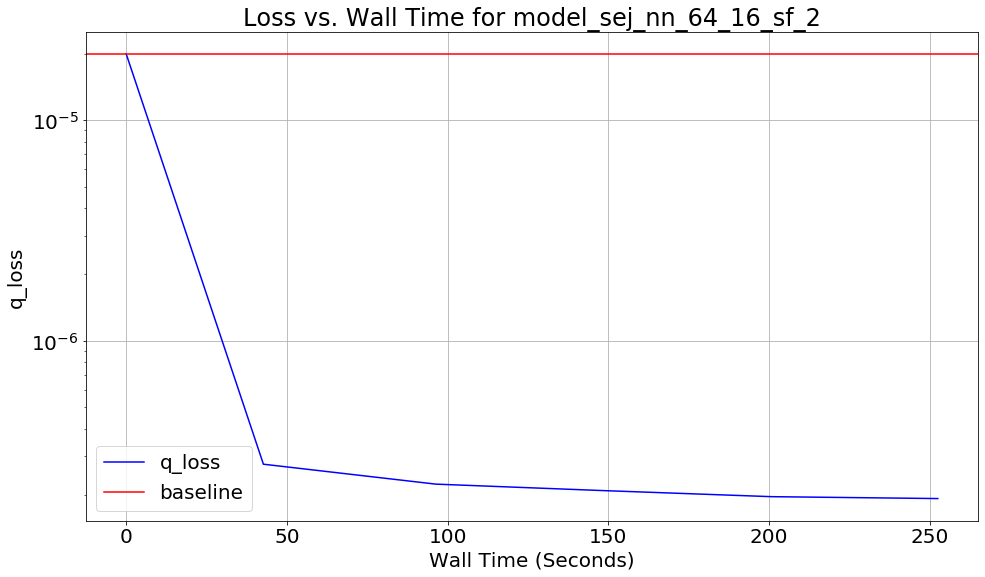

In [106]:
# Plot the loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_name, key='q_loss', baseline=q_loss_baseline)

### Train on Full Data Set with Perturbation Scale Factor = 4.0

In [107]:
# Build combined SEJ data sets with scale factor = 4
scale_factor = 4.0

# Data for this scale factor
ds_trn, ds_val, ds_tst = \
    combine_datasets_sej(num_data_sets=num_data_sets, batch_size=batch_size, 
                         seed0=seed0, scale_factor=scale_factor)

Loaded data from ../data/sej/3897864482.pickle.


Loaded data from ../data/sej/2803181541.pickle.
Loaded data from ../data/sej/314268072.pickle.
Loaded data from ../data/sej/3267070166.pickle.
Loaded data from ../data/sej/3217849491.pickle.



In [108]:
# Update data by scale factor
data_by_factor[scale_factor] = (ds_trn, ds_val, ds_tst)

In [110]:
# Get initial orbital elements of this dataset
orb_elt = orb_elts0(ds_val)

In [111]:
# Summarize initial orbital elements of this dataset
orb_elt_summary(orb_elt)

element:  mean     :  std dev  :  min      :  max
a1     :  1.006847 :  0.083922 :  0.732513 :  1.390527
a2     :  5.235960 :  0.443665 :  3.858552 :  7.521660
e1     :  0.054043 :  0.027857 :  0.000743 :  0.180544
e2     :  0.069416 :  0.033047 :  0.001912 :  0.234943
inc1   :  0.032240 :  0.024345 :  0.000050 :  0.149305
inc2   :  0.038946 :  0.025572 :  0.007735 :  0.161283


In [112]:
# Evaluate the NN model on the full validation data; save as baseline
hist0, q_loss_baseline = baseline_loss(model_kj, ds_val)

35/35 [==============================] - 4s 120ms/step - loss: 7.1569e-05 - q_loss: 2.1468e-05 - v_loss: 2.1257e-05 - a_loss: 2.8844e-05 - q0_rec_loss: 2.1866e-14 - v0_rec_loss: 2.0552e-14 - H_loss: 1.0287e-13 - P_loss: 3.8396e-14 - L_loss: 2.0293e-14


In [113]:
# Set up training - full data, scale factor = 4

# Number of training epochs
num_batches = 1
epochs_per_batch = 5

# Integer scale factor
sfi = int(scale_factor)

# Name of this model including scale factor
model_name = f'model_{model_code}_nn_{suffix}_sf_{sfi}'

# H5 file with model weights
model_h5 = f'../models/{folder}/{model_name}.h5'
# Name of the loss history in vartbl
hist_name = model_name.replace('model_', 'hist_')

# Status
print(f'Training for {num_batches} batches of {epochs_per_batch} epochs each.')
print(f'model_name = {model_name}')
print(f'model_h5 = {model_h5}')
print(f'hist_name = {hist_name}')

Training for 1 batches of 5 epochs each.
model_name = model_sej_nn_64_16_sf_4
model_h5 = ../models/sej/model_sej_nn_64_16_sf_4.h5
hist_name = hist_sej_nn_64_16_sf_4


In [114]:
# Attempt to load model or train on selected number of epochs
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics, loss_weights=loss_weights)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    print(f'Unable to load {model_name} from {model_h5}. Fitting...')
    hist = hist0
    for i in range_inc(num_batches):
        ts = datetime.datetime.now()
        st = ts.strftime('%Y-%m-%d %H:%M:%S')
        print(f'*** Training batch {i:3} *** {st}')
        hist = fit_model(model=model_nn,
                         model_name=model_name,
                         folder=folder,
                         ds=ds_trn, 
                         epochs=epochs_per_batch,
                         save_freq=save_freq,
                         prev_history = hist, 
                         batch_num=i)    
        vartbl[hist_name] = hist
        save_vartbl(vartbl, fname)

Loaded model_sej_nn_64_16_sf_4 from ../models/sej/model_sej_nn_64_16_sf_4.h5.


In [115]:
# Evaluate the trained model on the validation data
model_nn.evaluate(ds_val)

35/35 [==============================] - 7s 199ms/step - loss: 1.7530e-06 - q_loss: 4.3012e-07 - v_loss: 3.6151e-07 - a_loss: 9.6029e-07 - q0_rec_loss: 2.1866e-14 - v0_rec_loss: 2.0552e-14 - H_loss: 3.7173e-12 - P_loss: 3.9111e-14 - L_loss: 6.7190e-10


[1.7530306357522411e-06,
 4.3012267e-07,
 3.6151303e-07,
 9.602859e-07,
 2.1866459e-14,
 2.0551647e-14,
 3.717316e-12,
 3.9111336e-14,
 6.719033e-10]

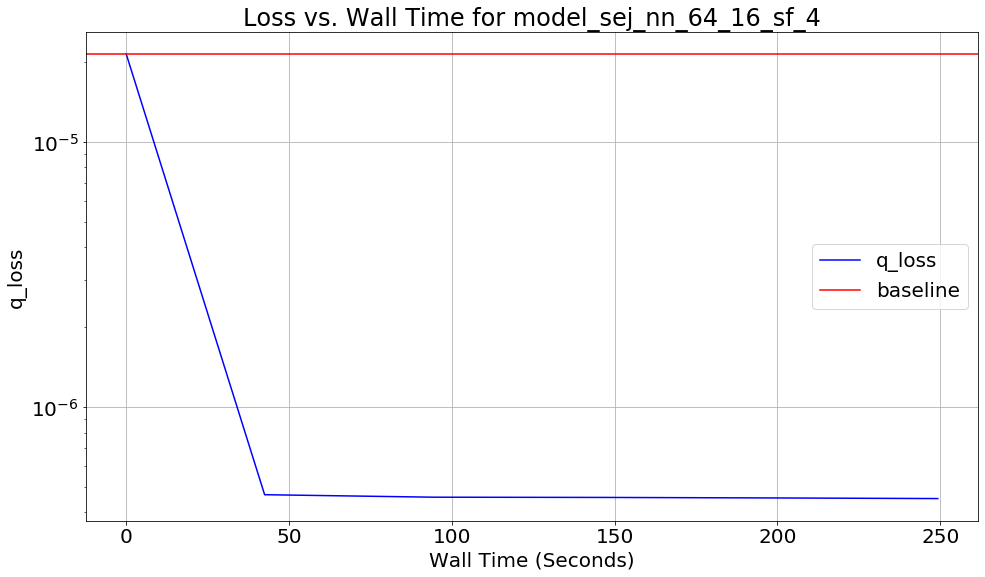

In [116]:
# Plot the loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_name, key='q_loss', baseline=q_loss_baseline)

### Train on Full Data Set with Perturbation Scale Factor = 8.0

In [117]:
# Build combined SEJ data sets with scale factor = 8
scale_factor = 8.0

# Data for this scale factor
ds_trn, ds_val, ds_tst = \
    combine_datasets_sej(num_data_sets=num_data_sets, batch_size=batch_size, 
                         seed0=seed0, scale_factor=scale_factor)

Loaded data from ../data/sej/179096976.pickle.


Loaded data from ../data/sej/1173183319.pickle.
Loaded data from ../data/sej/4030932250.pickle.
Loaded data from ../data/sej/541324388.pickle.
Loaded data from ../data/sej/1563688993.pickle.



In [118]:
# Update data by scale factor
data_by_factor[scale_factor] = (ds_trn, ds_val, ds_tst)

In [146]:
# Get initial orbital elements of this dataset
orb_elt = orb_elts0(ds_val)

In [147]:
# Summarize initial orbital elements of this dataset
orb_elt_summary(orb_elt)

element:  mean     :  std dev  :  min      :  max
a1     :  1.027906 :  0.172929 :  0.532019 :  1.979255
a2     :  5.344793 :  0.913103 :  2.880873 : 11.306460
e1     :  0.104769 :  0.053988 :  0.000819 :  0.345069
e2     :  0.114690 :  0.057800 :  0.000218 :  0.419079
inc1   :  0.064578 :  0.048851 :  0.000101 :  0.296592
inc2   :  0.068672 :  0.049087 :  0.006435 :  0.322143


In [148]:
# Evaluate the NN model on the full validation data; save as baseline
hist0, q_loss_baseline = baseline_loss(model_kj, ds_val)
baseline_tbl[scale_factor] = q_loss_baseline

35/35 [==============================] - 5s 129ms/step - loss: 7.1650e-04 - q_loss: 2.2443e-04 - v_loss: 2.2542e-04 - a_loss: 2.6665e-04 - q0_rec_loss: 2.4671e-14 - v0_rec_loss: 2.4154e-14 - H_loss: 1.2591e-13 - P_loss: 3.7284e-14 - L_loss: 2.0646e-14


In [149]:
model_nn.evaluate(ds_val)

35/35 [==============================] - 5s 130ms/step - loss: 0.0022 - q_loss: 4.9761e-04 - v_loss: 5.5041e-04 - a_loss: 0.0011 - q0_rec_loss: 2.4671e-14 - v0_rec_loss: 2.4154e-14 - H_loss: 2.4864e-08 - P_loss: 3.7994e-14 - L_loss: 1.5458e-09


[0.0021935018976884228,
 0.00049760944,
 0.00055041205,
 0.0011454534,
 2.4670629e-14,
 2.4153966e-14,
 2.4863782e-08,
 3.7993968e-14,
 1.5457805e-09]

In [154]:
# Set up training - full data, scale factor = 8

# Number of training epochs
num_batches=1
epochs_per_batch = 5

# Integer scale factor
sfi = int(scale_factor)

# Name of this model including scale factor
model_name = f'model_{model_code}_nn_{suffix}_sf_{sfi}'

# H5 file with model weights
model_h5 = f'../models/{folder}/{model_name}.h5'
# Name of the loss history in vartbl
hist_name = model_name.replace('model_', 'hist_')

# Status
print(f'Training for {num_batches} batches of {epochs_per_batch} epochs each.')
print(f'model_name = {model_name}')
print(f'model_h5 = {model_h5}')
print(f'hist_name = {hist_name}')

Training for 1 batches of 5 epochs each.
model_name = model_sej_nn_64_16_sf_8
model_h5 = ../models/sej/model_sej_nn_64_16_sf_8.h5
hist_name = hist_sej_nn_64_16_sf_8


In [155]:
# Use slow learning rate
optimizer_slow = keras.optimizers.Adam(learning_rate=1.0E-8)
model_nn.compile(loss=loss, optimizer=optimizer_slow, metrics=metrics, loss_weights=loss_weights)

In [156]:
# Attempt to load model or train on selected number of epochs
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics, loss_weights=loss_weights)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    print(f'Unable to load {model_name} from {model_h5}. Fitting...')
    hist = hist0
    for i in range_inc(num_batches):
        ts = datetime.datetime.now()
        st = ts.strftime('%Y-%m-%d %H:%M:%S')
        print(f'*** Training batch {i:3} *** {st}')
        hist = fit_model(model=model_nn,
                         model_name=model_name,
                         folder=folder,
                         ds=ds_trn, 
                         epochs=epochs_per_batch,
                         save_freq=save_freq,
                         prev_history = hist, 
                         batch_num=i)   
        vartbl[hist_name] = hist
        save_vartbl(vartbl, fname)

Unable to load model_sej_nn_64_16_sf_8 from ../models/sej/model_sej_nn_64_16_sf_8.h5. Fitting...
*** Training batch   1 *** 2019-08-23 15:39:54
Epoch 1/5
194/195 [============================>.] - ETA: 0s - loss: 0.0014 - q_loss: 2.9339e-04 - v_loss: 3.4111e-04 - a_loss: 7.2621e-04 - q0_rec_loss: 2.5069e-14 - v0_rec_loss: 2.4218e-14 - H_loss: 2.2148e-08 - P_loss: 3.7933e-14 - L_loss: 7.1933e-10
Epoch 0001; loss 1.36e-03; elapsed 0:01:06
195/195 [==============================] - 55s 282ms/step - loss: 0.0014 - q_loss: 2.9455e-04 - v_loss: 3.4194e-04 - a_loss: 7.2664e-04 - q0_rec_loss: 2.5061e-14 - v0_rec_loss: 2.4211e-14 - H_loss: 2.2144e-08 - P_loss: 3.7930e-14 - L_loss: 7.1803e-10
Epoch 2/5
194/195 [============================>.] - ETA: 0s - loss: 9.5051e-04 - q_loss: 2.1605e-04 - v_loss: 2.3380e-04 - a_loss: 5.0063e-04 - q0_rec_loss: 2.5069e-14 - v0_rec_loss: 2.4218e-14 - H_loss: 2.0917e-08 - P_loss: 3.7939e-14 - L_loss: 5.0362e-10
Epoch 0002; loss 9.54e-04; elapsed 0:02:00
195/195

In [125]:
# Evaluate the trained model on the validation data
model_nn.evaluate(ds_val)

35/35 [==============================] - 6s 182ms/step - loss: 6.3306e-04 - q_loss: 1.9872e-04 - v_loss: 1.9979e-04 - a_loss: 2.3456e-04 - q0_rec_loss: 2.4671e-14 - v0_rec_loss: 2.4154e-14 - H_loss: 3.3488e-11 - P_loss: 3.7957e-14 - L_loss: 7.5080e-11


[0.0006330637446548541,
 0.0001987196,
 0.00019978744,
 0.00023455615,
 2.4670629e-14,
 2.4153966e-14,
 3.348845e-11,
 3.795687e-14,
 7.508005e-11]

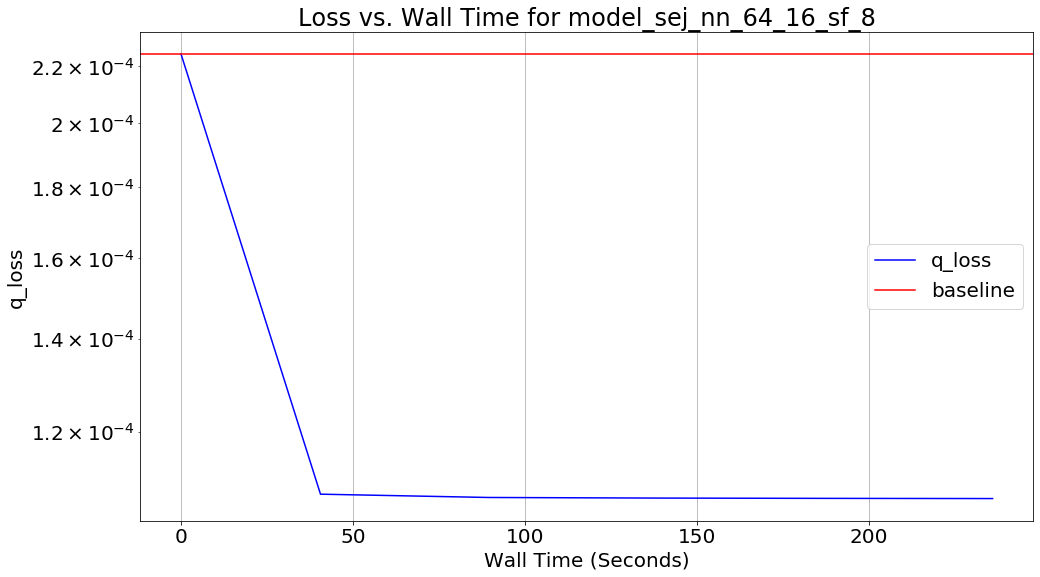

In [126]:
# Plot the loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_name, key='q_loss', baseline=q_loss_baseline)

### Train on Full Data Set with Perturbation Scale Factor = 16.0

In [127]:
# Build combined SEJ data sets with scale factor = 16
scale_factor = 16.0

# Data for this scale factor
ds_trn, ds_val, ds_tst = \
    combine_datasets_sej(num_data_sets=num_data_sets, batch_size=batch_size, 
                         seed0=seed0, scale_factor=scale_factor)

Loaded data from ../data/sej/3424916289.pickle.


Loaded data from ../data/sej/2204468614.pickle.
Loaded data from ../data/sej/919337931.pickle.
Loaded data from ../data/sej/3872074421.pickle.
Loaded data from ../data/sej/2612846320.pickle.



In [128]:
# Update data by scale factor
data_by_factor[scale_factor] = (ds_trn, ds_val, ds_tst)

In [129]:
# Get initial orbital elements of this dataset
orb_elt = orb_elts0(ds_val)

In [130]:
# Summarize initial orbital elements of this dataset
orb_elt_summary(orb_elt)

element:  mean     :  std dev  :  min      :  max
a1     :  1.120197 :  0.397048 :  0.258224 :  4.967225
a2     :  5.836369 :  2.113485 :  1.501714 : 37.963409
e1     :  0.206312 :  0.105575 :  0.001906 :  0.689176
e2     :  0.214678 :  0.108590 :  0.002498 :  0.783685
inc1   :  0.130050 :  0.099360 :  0.000207 :  0.751228
inc2   :  0.132906 :  0.099254 :  0.002371 :  0.716278


In [131]:
# Evaluate the NN model on the full validation data; save as baseline
hist0, q_loss_baseline = baseline_loss(model_kj, ds_val)
baseline_tbl[scale_factor] = q_loss_baseline

35/35 [==============================] - 4s 118ms/step - loss: 0.0652 - q_loss: 0.0170 - v_loss: 0.0180 - a_loss: 0.0302 - q0_rec_loss: 2.7136e-14 - v0_rec_loss: 2.7719e-14 - H_loss: 8.9815e-13 - P_loss: 3.5947e-14 - L_loss: 2.1739e-14


In [136]:
# Set up training - full data, scale factor = 16

# Number of training epochs
num_batches=1
epochs_per_batch = 5

# Integer scale factor
sfi = int(scale_factor)

# Name of this model including scale factor
model_name = f'model_{model_code}_nn_{suffix}_sf_{sfi}'

# H5 file with model weights
model_h5 = f'../models/{folder}/{model_name}.h5'
# Name of the loss history in vartbl
hist_name = model_name.replace('model_', 'hist_')

# Status
print(f'Training for {num_batches} batches of {epochs_per_batch} epochs each.')
print(f'model_name = {model_name}')
print(f'model_h5 = {model_h5}')
print(f'hist_name = {hist_name}')

Training for 1 batches of 5 epochs each.
model_name = model_sej_nn_64_16_sf_16
model_h5 = ../models/sej/model_sej_nn_64_16_sf_16.h5
hist_name = hist_sej_nn_64_16_sf_16


In [137]:
# Attempt to load model or train on selected number of epochs
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics, loss_weights=loss_weights)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    print(f'Unable to load {model_name} from {model_h5}. Fitting...')
    hist = hist0
    for i in range_inc(num_batches):
        ts = datetime.datetime.now()
        st = ts.strftime('%Y-%m-%d %H:%M:%S')
        print(f'*** Training batch {i:3} *** {st}')
        hist = fit_model(model=model_nn,
                         model_name=model_name,
                         folder=folder,
                         ds=ds_trn, 
                         epochs=epochs_per_batch,
                         save_freq=save_freq,
                         prev_history = hist, 
                         batch_num=i)    
        vartbl[hist_name] = hist
        save_vartbl(vartbl, fname)

Unable to load model_sej_nn_64_16_sf_16 from ../models/sej/model_sej_nn_64_16_sf_16.h5. Fitting...
*** Training batch   1 *** 2019-08-23 14:54:18
Epoch 1/5
194/195 [============================>.] - ETA: 0s - loss: 0.0587 - q_loss: 0.0181 - v_loss: 0.0175 - a_loss: 0.0231 - q0_rec_loss: 2.7172e-14 - v0_rec_loss: 2.7676e-14 - H_loss: 9.7941e-08 - P_loss: 3.6452e-14 - L_loss: 1.2724e-08
Epoch 0001; loss 5.87e-02; elapsed 0:01:01
195/195 [==============================] - 51s 263ms/step - loss: 0.0587 - q_loss: 0.0181 - v_loss: 0.0175 - a_loss: 0.0231 - q0_rec_loss: 2.7176e-14 - v0_rec_loss: 2.7690e-14 - H_loss: 9.7944e-08 - P_loss: 3.6447e-14 - L_loss: 1.2697e-08
Epoch 2/5
194/195 [============================>.] - ETA: 0s - loss: 0.0587 - q_loss: 0.0181 - v_loss: 0.0174 - a_loss: 0.0231 - q0_rec_loss: 2.7172e-14 - v0_rec_loss: 2.7676e-14 - H_loss: 9.6670e-08 - P_loss: 3.6472e-14 - L_loss: 1.1859e-08
Epoch 0002; loss 5.87e-02; elapsed 0:01:54
195/195 [==============================] - 43

In [142]:
# Additional round of training with slow learning rate
num_batches=5
optimizer_slow = keras.optimizers.Adam(learning_rate=1.0E-8)
model_nn.compile(loss=loss, optimizer=optimizer_slow, metrics=metrics, loss_weights=loss_weights)

for i in range_inc(num_batches):
    ts = datetime.datetime.now()
    st = ts.strftime('%Y-%m-%d %H:%M:%S')
    print(f'*** Training batch {i:3} *** {st}')
    hist = fit_model(model=model_nn,
                     model_name=model_name,
                     folder=folder,
                     ds=ds_trn, 
                     epochs=epochs_per_batch,
                     save_freq=save_freq,
                     prev_history = hist, 
                     batch_num=i)    
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

*** Training batch   1 *** 2019-08-23 15:03:18
Epoch 1/5
194/195 [============================>.] - ETA: 0s - loss: 0.0584 - q_loss: 0.0182 - v_loss: 0.0174 - a_loss: 0.0228 - q0_rec_loss: 2.7172e-14 - v0_rec_loss: 2.7676e-14 - H_loss: 9.4458e-08 - P_loss: 3.6458e-14 - L_loss: 7.4681e-09
Epoch 0001; loss 5.85e-02; elapsed 0:01:01
195/195 [==============================] - 52s 268ms/step - loss: 0.0585 - q_loss: 0.0182 - v_loss: 0.0174 - a_loss: 0.0228 - q0_rec_loss: 2.7176e-14 - v0_rec_loss: 2.7690e-14 - H_loss: 9.4452e-08 - P_loss: 3.6453e-14 - L_loss: 7.4630e-09
Epoch 2/5
194/195 [============================>.] - ETA: 0s - loss: 0.0584 - q_loss: 0.0182 - v_loss: 0.0174 - a_loss: 0.0228 - q0_rec_loss: 2.7172e-14 - v0_rec_loss: 2.7676e-14 - H_loss: 9.4032e-08 - P_loss: 3.6466e-14 - L_loss: 6.6369e-09
Epoch 0002; loss 5.84e-02; elapsed 0:01:53
195/195 [==============================] - 42s 217ms/step - loss: 0.0584 - q_loss: 0.0182 - v_loss: 0.0174 - a_loss: 0.0228 - q0_rec_loss: 2.717

In [143]:
# Evaluate the trained model on the validation data
model_nn.evaluate(ds_val)

35/35 [==============================] - 10s 298ms/step - loss: 0.0589 - q_loss: 0.0179 - v_loss: 0.0173 - a_loss: 0.0236 - q0_rec_loss: 2.7136e-14 - v0_rec_loss: 2.7719e-14 - H_loss: 1.0376e-07 - P_loss: 3.6646e-14 - L_loss: 6.9247e-09


[0.05888491134558405,
 0.017937697,
 0.017348893,
 0.023598202,
 2.7136208e-14,
 2.7718559e-14,
 1.0376255e-07,
 3.6646243e-14,
 6.924671e-09]

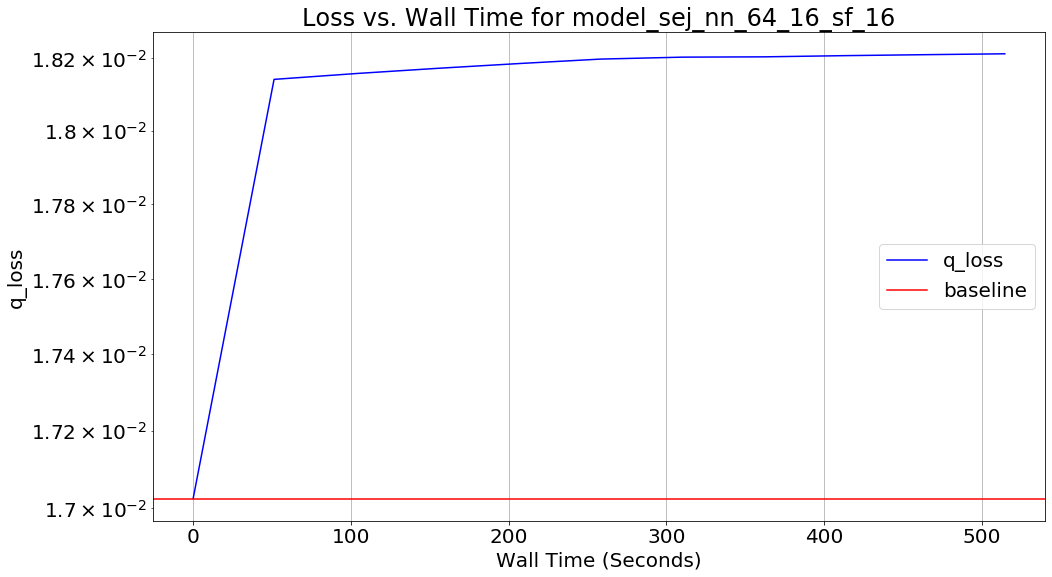

In [144]:
# Plot the loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_name, key='q_loss', baseline=q_loss_baseline)

### Train on Full Data Set with Perturbation Scale Factor = 32.0

In [ ]:
# Build combined SEJ data sets with scale factor = 32
scale_factor = 32.0

# Data for this scale factor
ds_trn, ds_val, ds_tst = \
    combine_datasets_sej(num_data_sets=num_data_sets, batch_size=batch_size, 
                         seed0=seed0, scale_factor=scale_factor)

In [ ]:
# Update data by scale factor
data_by_factor[scale_factor] = (ds_trn, ds_val, ds_tst)

In [ ]:
# Get initial orbital elements of this dataset
orb_elt = orb_elts0(ds_val)

In [ ]:
# Summarize initial orbital elements of this dataset
orb_elt_summary(orb_elt)

In [ ]:
# Evaluate the NN model on the full validation data; save as baseline
hist0, q_loss_baseline = baseline_loss(model_kj, ds_val)
baseline_tbl[scale_factor] = q_loss_baseline

In [ ]:
# Set up training - full data, scale factor = 2

# Number of training epochs
num_batches=1
epochs_per_batch = 5

# Integer scale factor
sfi = int(scale_factor)

# Name of this model including scale factor
model_name = f'model_{model_code}_nn_{suffix}_sf_{sfi}'

# H5 file with model weights
model_h5 = f'../models/{folder}/{model_name}.h5'
# Name of the loss history in vartbl
hist_name = model_name.replace('model_', 'hist_')

# Status
print(f'Training for {num_batches} batches of {epochs_per_batch} epochs each.')
print(f'model_name = {model_name}')
print(f'model_h5 = {model_h5}')
print(f'hist_name = {hist_name}')

In [ ]:
# Attempt to load model or train on selected number of epochs
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics, loss_weights=loss_weights)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    print(f'Unable to load {model_name} from {model_h5}. Fitting...')
    hist = hist0
    for i in range_inc(num_batches):
        ts = datetime.datetime.now()
        st = ts.strftime('%Y-%m-%d %H:%M:%S')
        print(f'*** Training batch {i:3} *** {st}')
        hist = fit_model(model=model_nn,
                         model_name=model_name,
                         folder=folder,
                         ds=ds_trn, 
                         epochs=epochs_per_batch,
                         save_freq=save_freq,
                         prev_history = hist, 
                         batch_num=i)
        vartbl[hist_name] = hist
        save_vartbl(vartbl, fname)

In [ ]:
# Evaluate the trained model on the validation data
model_nn.evaluate(ds_val)

In [ ]:
# Plot the loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_name, key='q_loss', baseline=q_loss_baseline)

### Train on Full Data Set with Perturbation Scale Factor = 64.0

### Train on Full Data Set with Perturbation Scale Factor = 128.0

### Train on Full Data Set with Perturbation Scale Factor = 256.0